# EHH decay artwork

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}
rcParams['figure.dpi'] = 120

In [2]:
#grab the npy array made in ag1000g paper 1 vgsc notebook
p1clus = np.load('../data/vgsc_cluster_membership.npy')

In [3]:
#make this into a dictionary
p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
np.unique(p1list)[1:], len(p1list)

(array(['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5'], 
       dtype='<U2'), 1530)

In [4]:
nlist = list(np.unique(p1list)[1:])
nlist

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

In [50]:
clust_dict = {n: set(np.nonzero(p1list == n)[0]) for n in nlist}
#clust_dict['S2']

In [51]:
pos_995S = 2422651
pos_995F = 2422652
pos_1527T = 2429617

In [52]:
def setup_ehh_data():
    global haps_ehh
    global pos_ehh

    # load haplotypes
    callset_haps = np.load('../data/haps_phase1.npz')
    haps = allel.HaplotypeArray(callset_haps['haplotypes'])
    pos = allel.SortedIndex(callset_haps['POS'])
    ann = callset_haps['ANN']

    # perform allele count - needed to locate singletons  
    ac = haps.count_alleles(max_allele=3)

    # define types of variants to include in EHH analysis - should be mostly neutral
    loc_type_neutral = ((ann['Annotation'] == b'intergenic_region') | 
                        (ann['Annotation'] == b'intron_variant') |
                        (ann['Annotation'] == b'downstream_gene_variant') |
                        (ann['Annotation'] == b'upstream_gene_variant') |
                        (ann['Annotation'] == b'synonymous_variant') |
                        (ann['Annotation'] == b'3_prime_UTR_variant') |
                        (ann['Annotation'] == b'5_prime_UTR_variant') 
                        )
    print('neutral', np.count_nonzero(loc_type_neutral), loc_type_neutral.shape)

    # locate singletons - will exclude from EHH analysis
    # NB the EHH analysis doesn't need the multiallelics 
    loc_sgl_bi = (ac[:, :2].min(axis=1) == 1) & (ac.is_biallelic_01())
    loc_nosgl_bi = (ac[:, :2].min(axis=1) > 1) & (ac.is_biallelic_01())
    print('sgl/nosgl', np.count_nonzero(loc_sgl_bi), np.count_nonzero(loc_nosgl_bi), loc_nosgl_bi.shape)

    # these are the variants to use for EHH 
    loc_ehh = loc_type_neutral & loc_nosgl_bi
    
    # add back in driver mutations
    for p in pos_995S, pos_995F, pos_1527T:
        loc_ehh[pos.locate_key(p)] = True
    
    print('ehh', np.count_nonzero(loc_ehh), loc_ehh.shape)

    haps_ehh = haps[loc_ehh]
    pos_ehh = pos[loc_ehh]
    
setup_ehh_data()

neutral 326952 (341998,)
sgl/nosgl 107220 234555 (341998,)
ehh 225793 (341998,)


In [53]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [54]:
outbreak_labels = sorted(clust_dict)
outbreak_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

## Identify core haplotypes

In [55]:
def plot_delta_af(core, flank, set1, set2, figsize=(10, 2)):
    
    # subset to region
    loc_region = pos_ehh.locate_range(core - flank, core + flank)
    pos_region = pos_ehh[loc_region]
    n_snps = pos_region.shape[0]
    haps_region = haps_ehh[loc_region]
    
    # compute delta allele frequency
    subpops = {set1: sorted(clust_dict[set1]), set2: sorted(clust_dict[set2])}
    acs = haps_region.count_alleles_subpops(subpops)
    aaf1 = acs[set1].to_frequencies()[:, 1]
    aaf2 = acs[set2].to_frequencies()[:, 1]
    delta_af = np.fabs(aaf1 - aaf2)
    
    # plot
    fig, ax = plt.subplots(figsize=figsize)
#     x = np.concatenate([-np.arange(0, idx_core)[::-1], 
#                         np.arange(idx_core, n_snps) - idx_core])
#     y = delta_af

    ax.plot(pos_region, delta_af, marker='o', mec='k', mfc='none', linestyle=' ')
    loc_diff = delta_af > .85
    pos_diff = pos_region[loc_diff]
    ax.set_xticks(pos_diff)
    ax.set_xticklabels(pos_diff - core)
    ax.axvline(core, linestyle='--', lw=1)
    ax.grid(axis='both')
    ax.set_title('%s vs %s' % (set1, set2))
    ax.set_xlim(core - flank, core + flank)
    ax.set_ylabel('Delta allele frequency')
    ax.set_xlabel('Position relative to core (bp)')


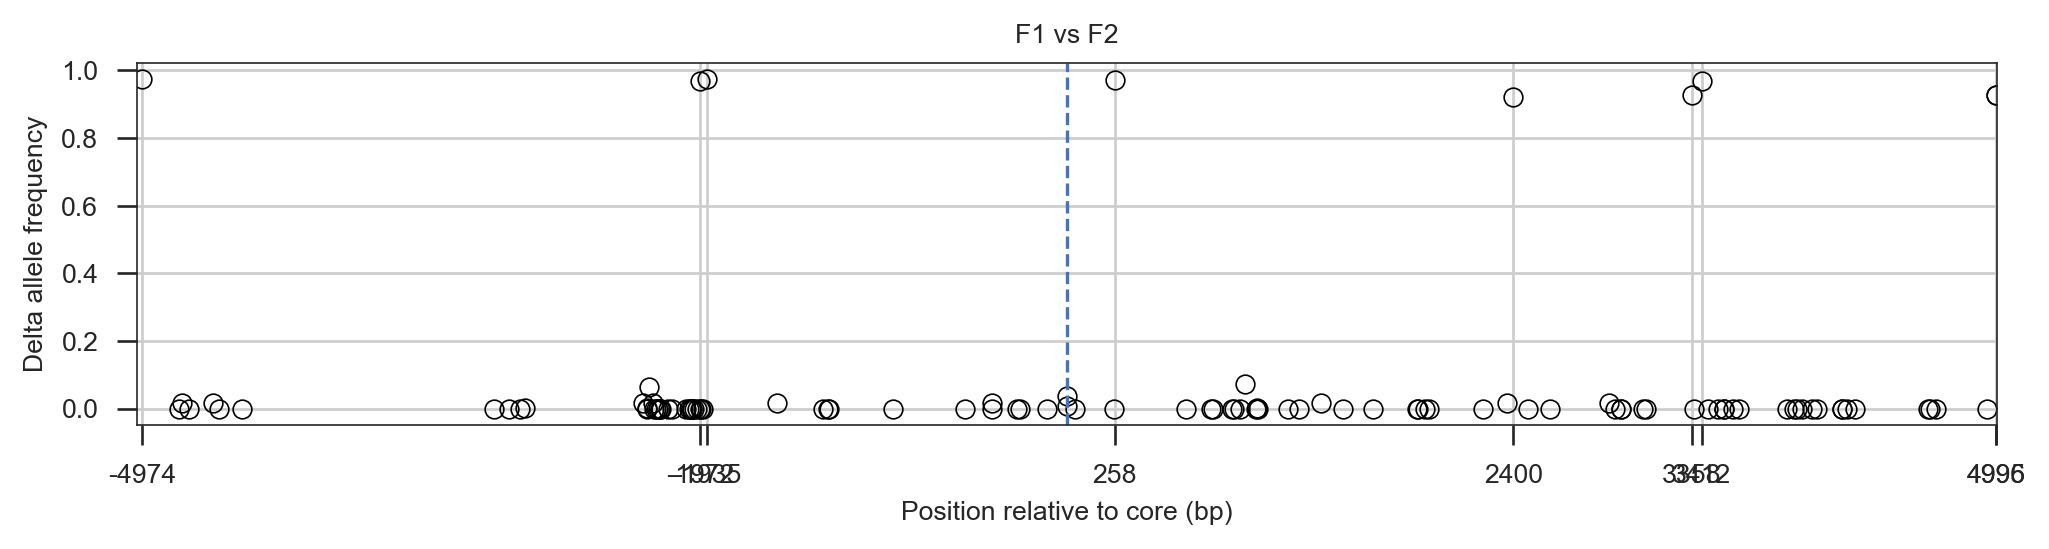

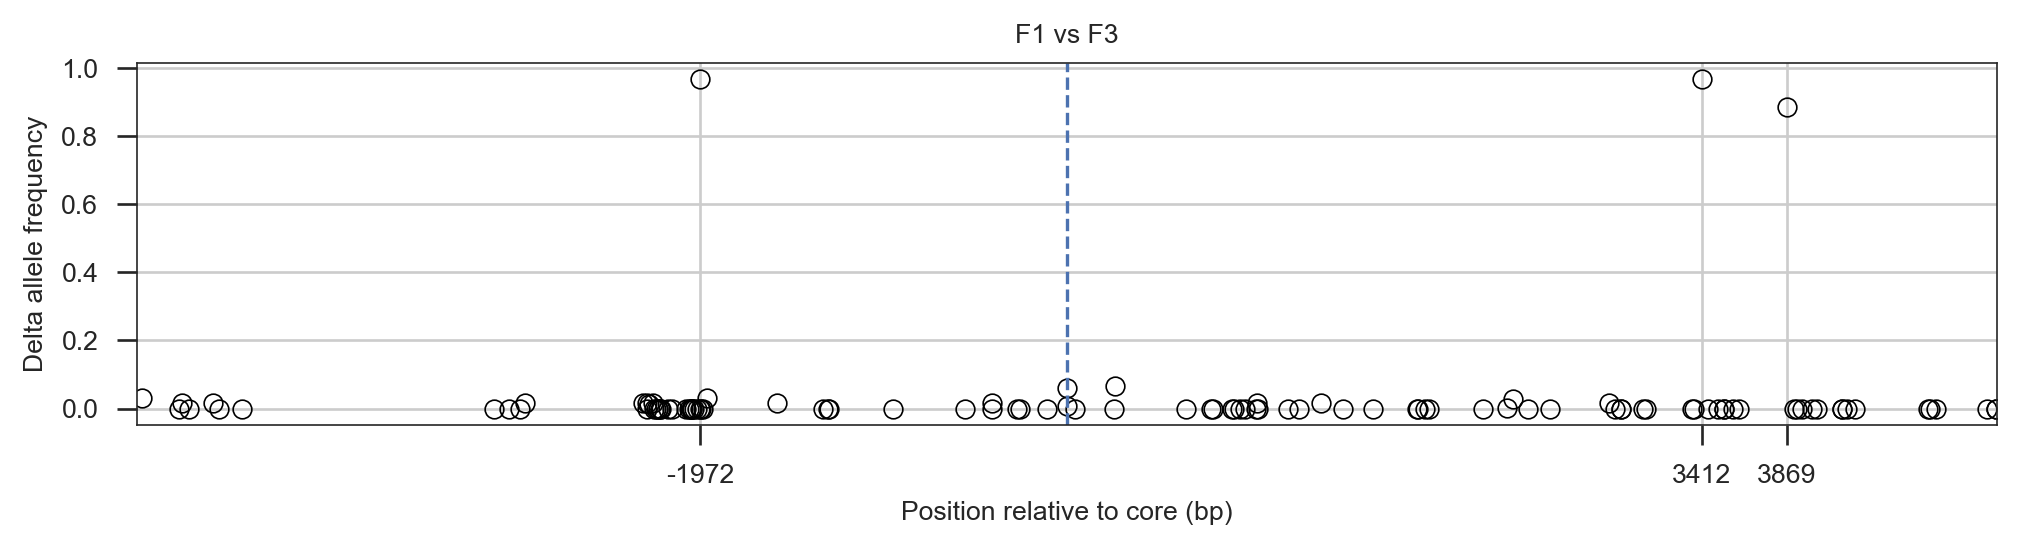

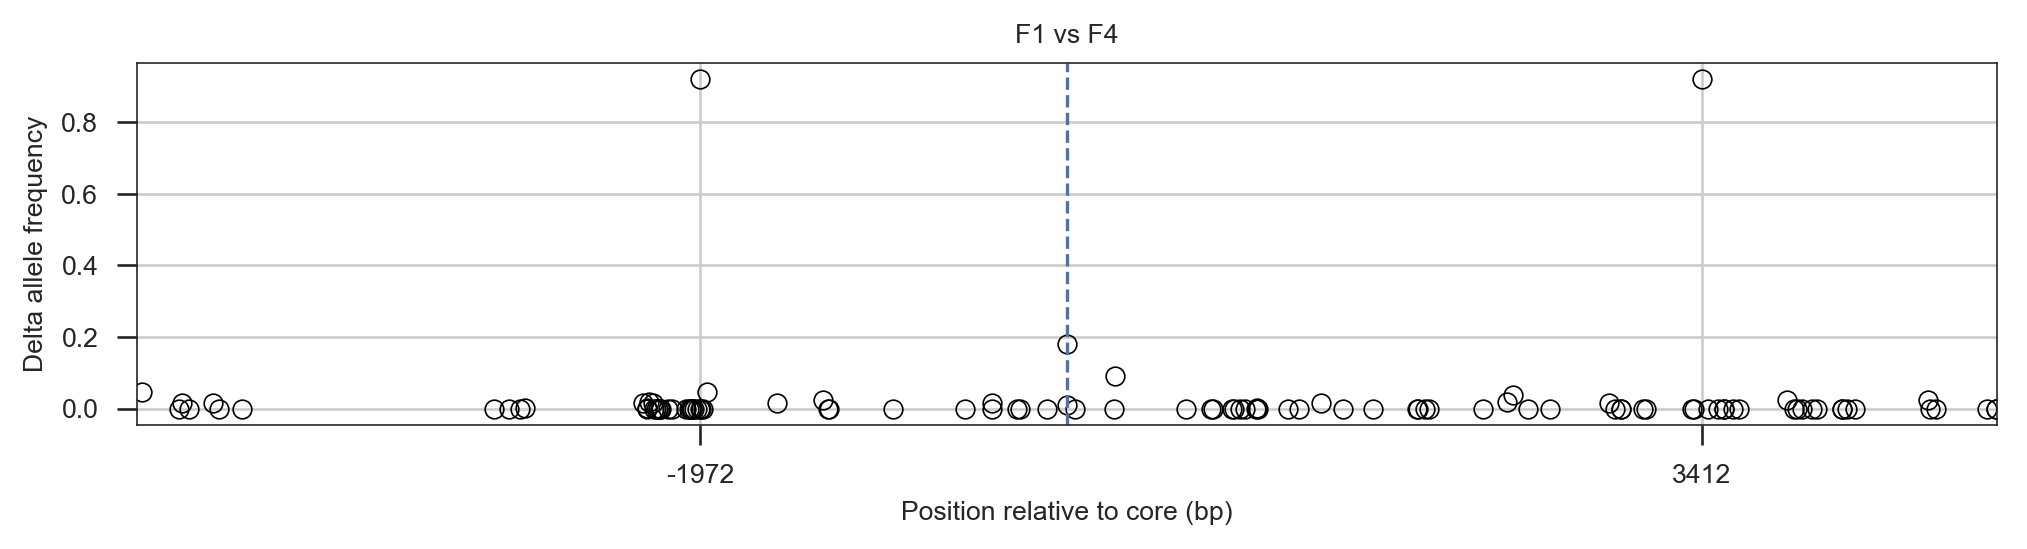

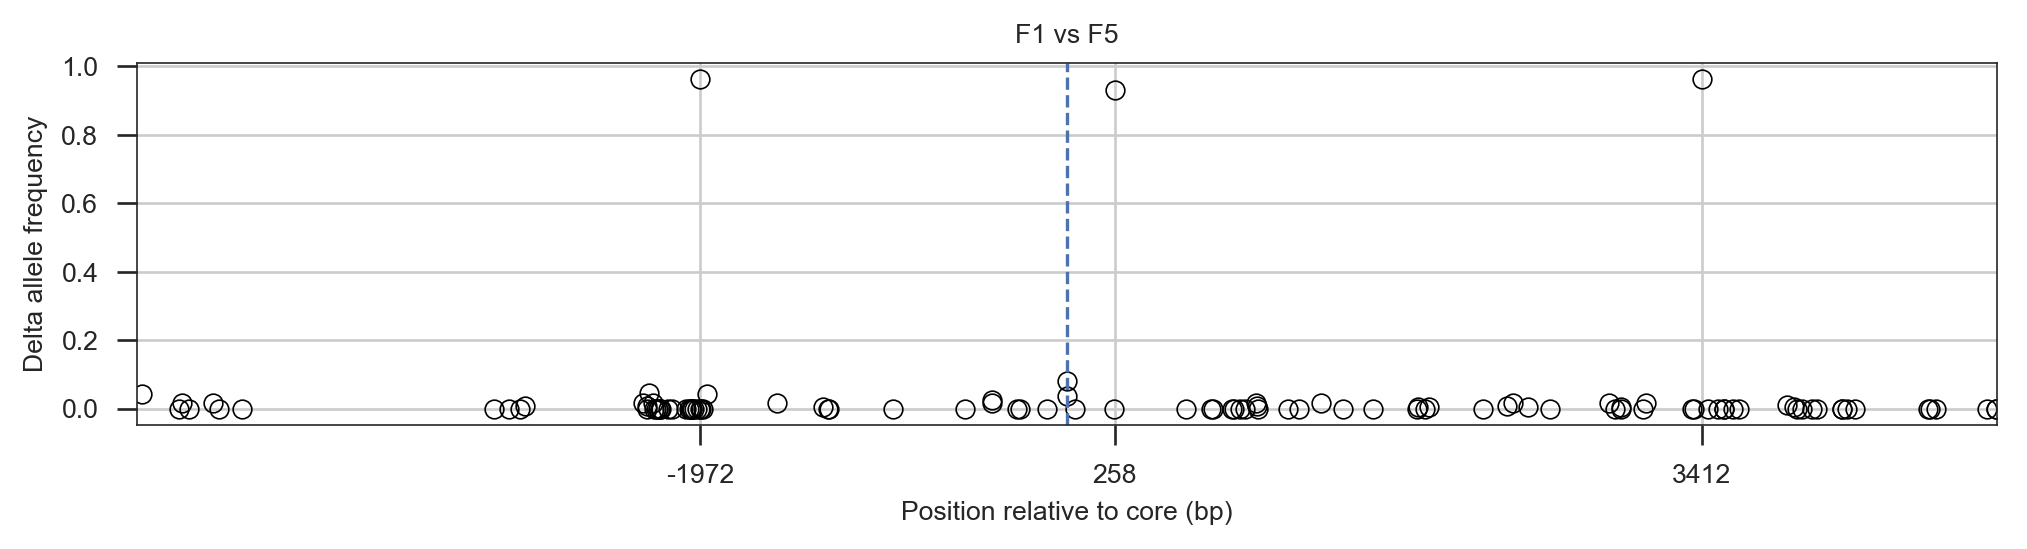

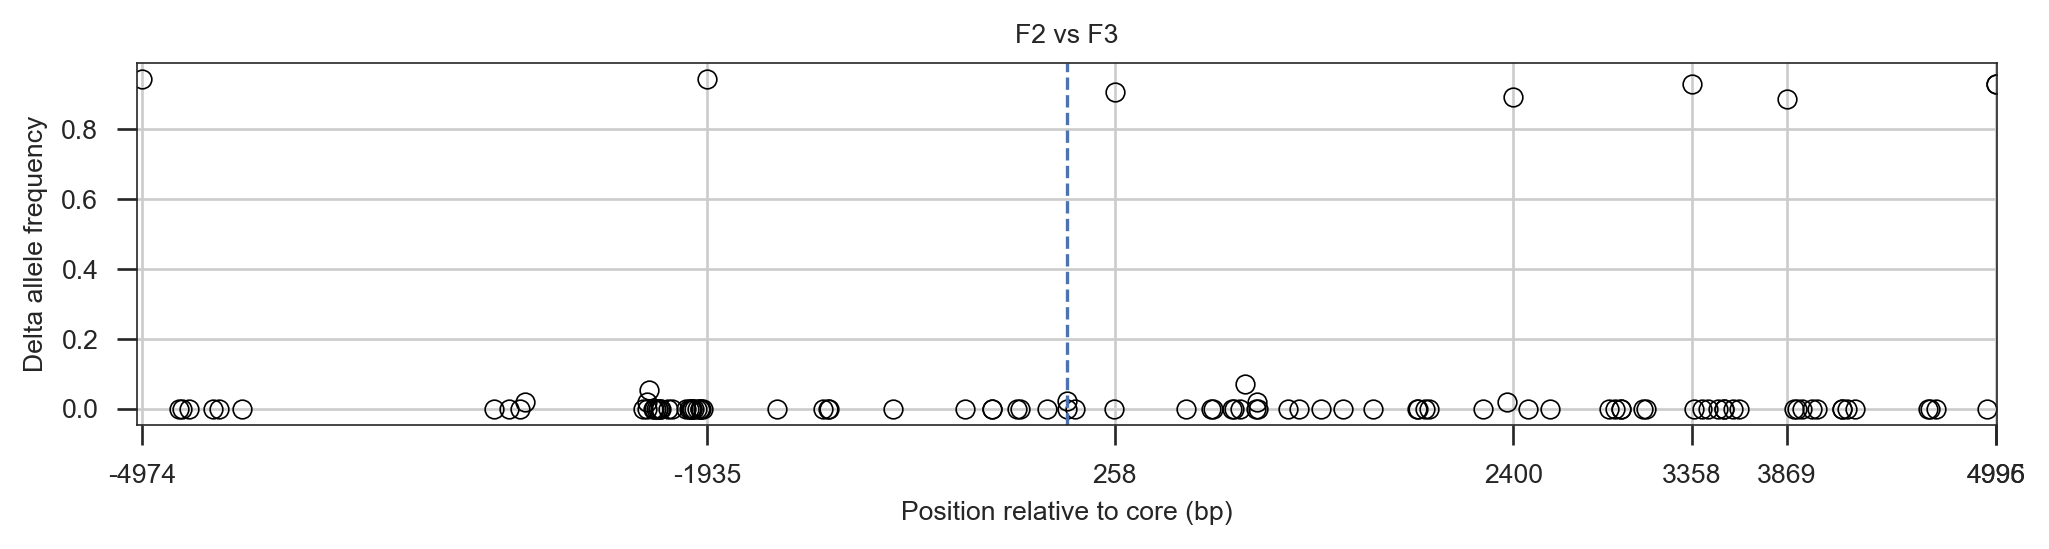

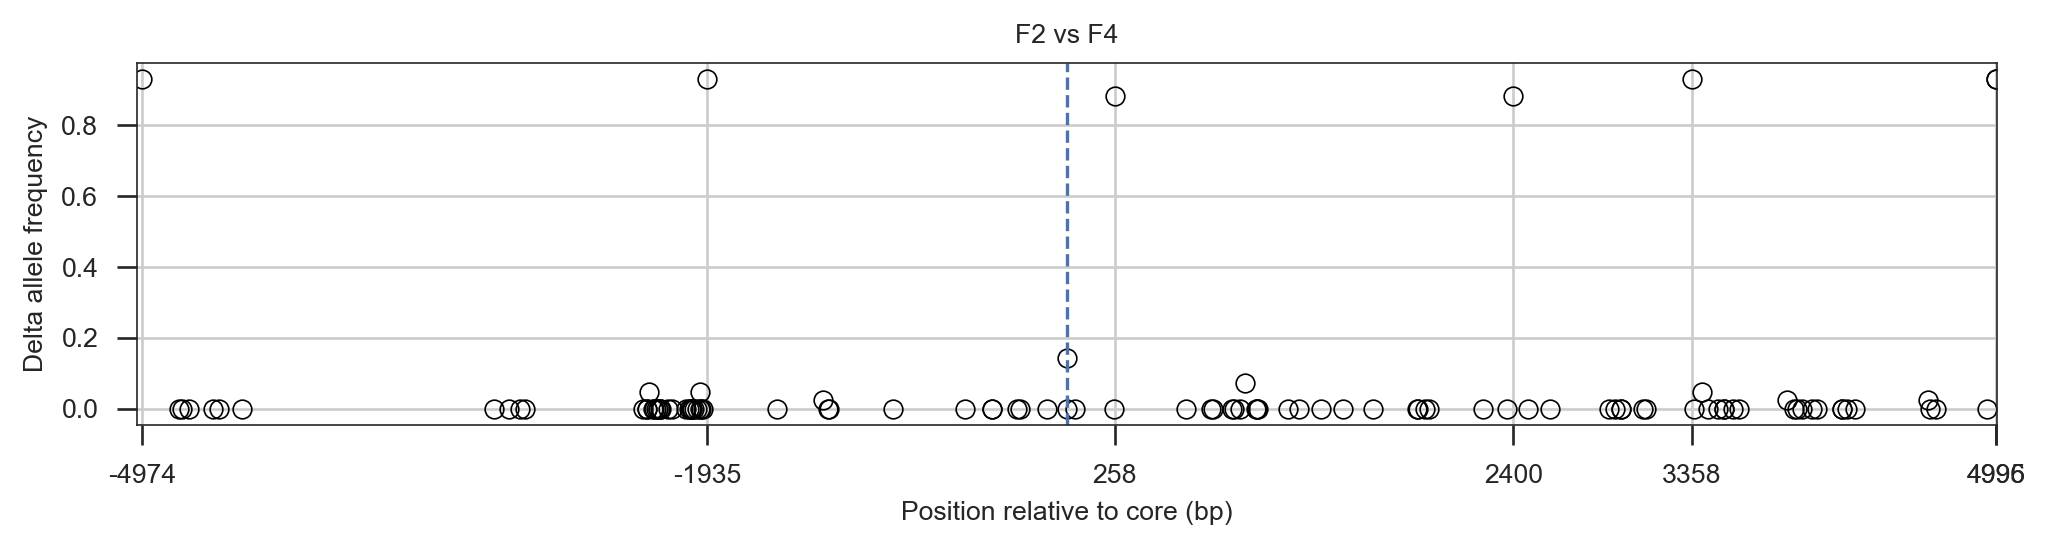

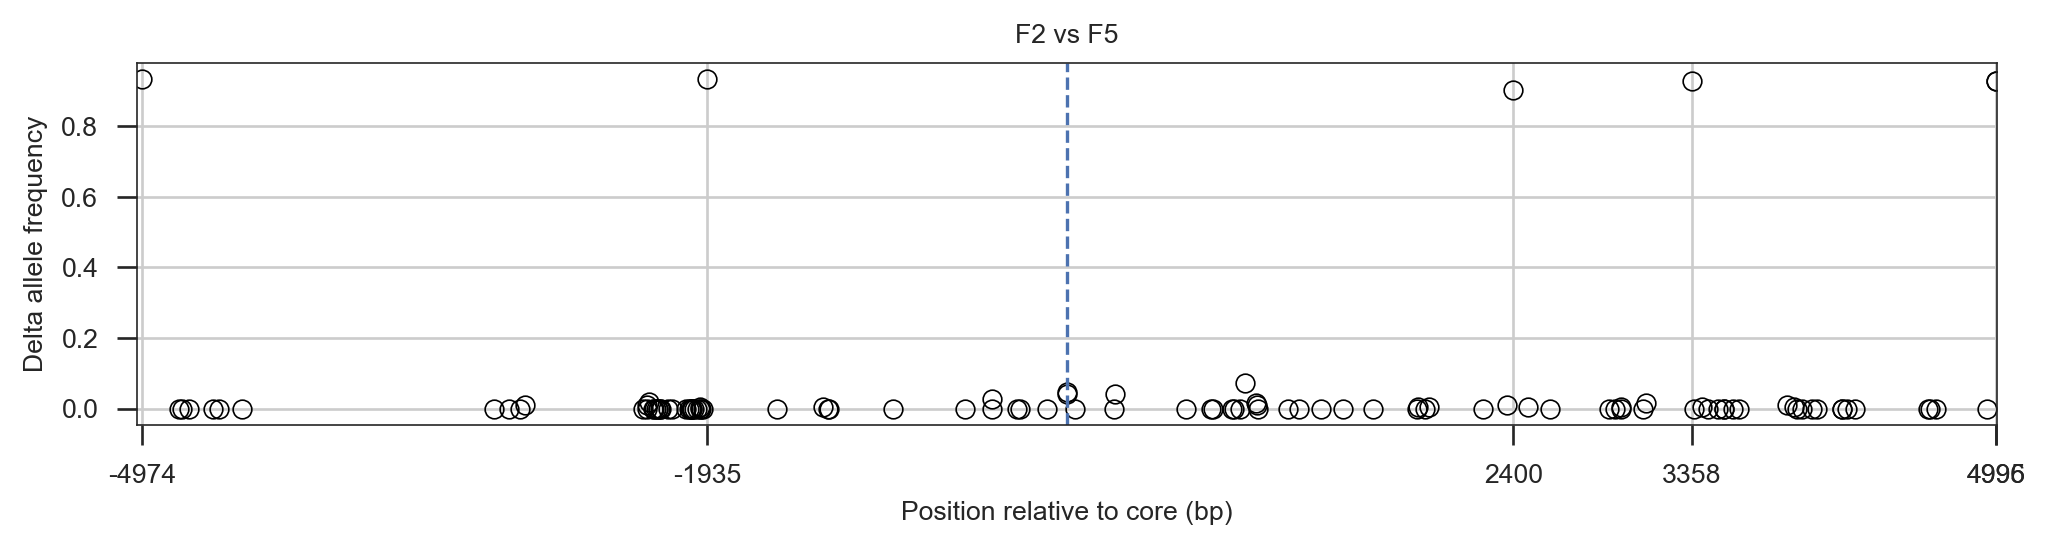

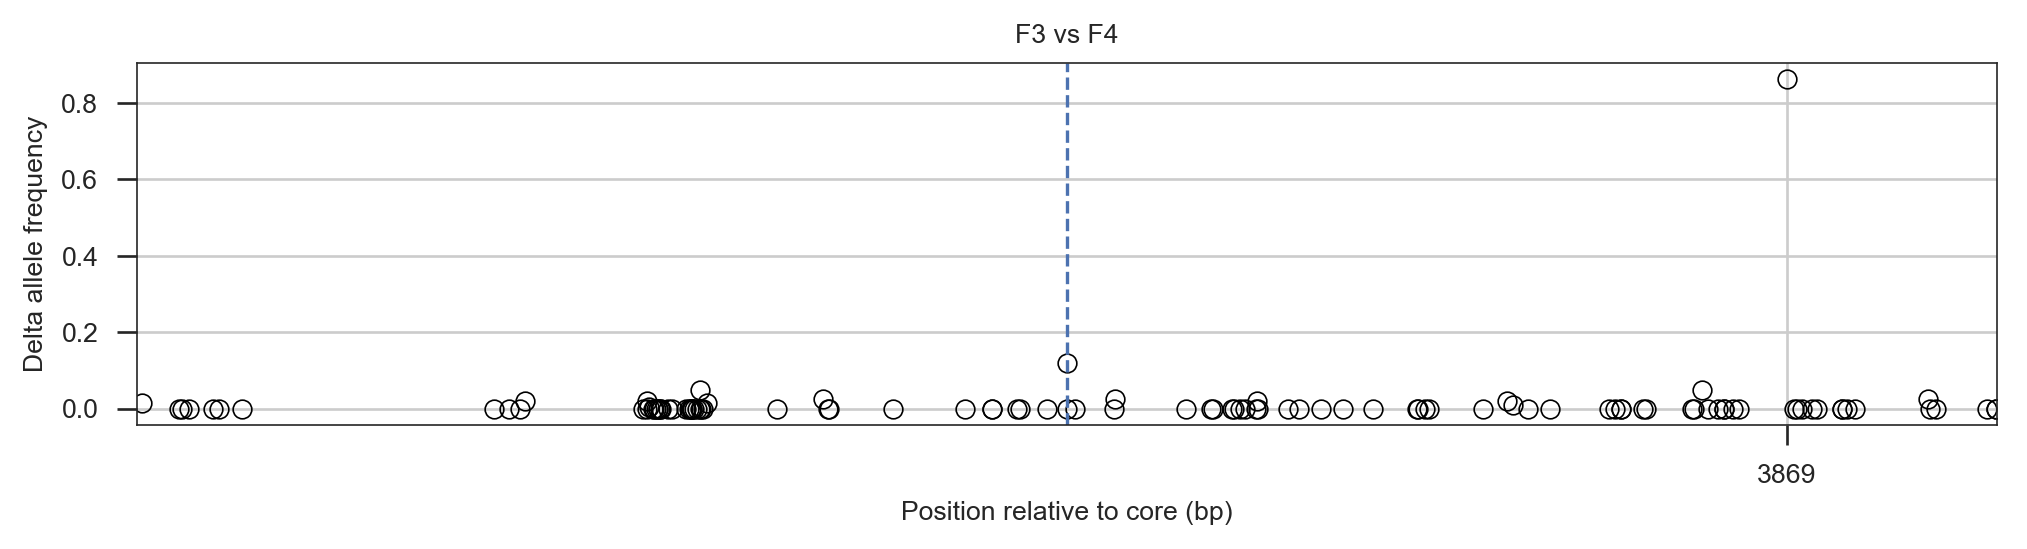

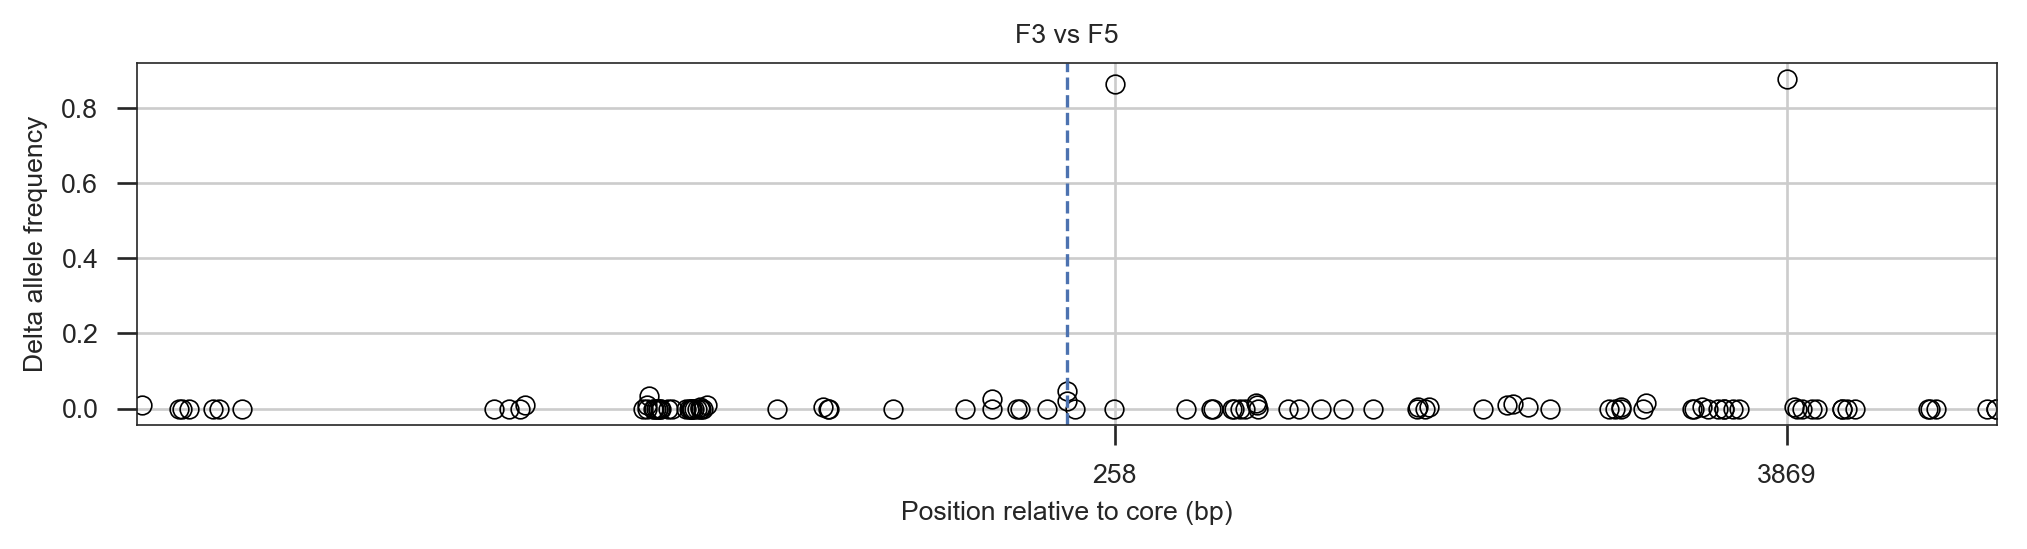

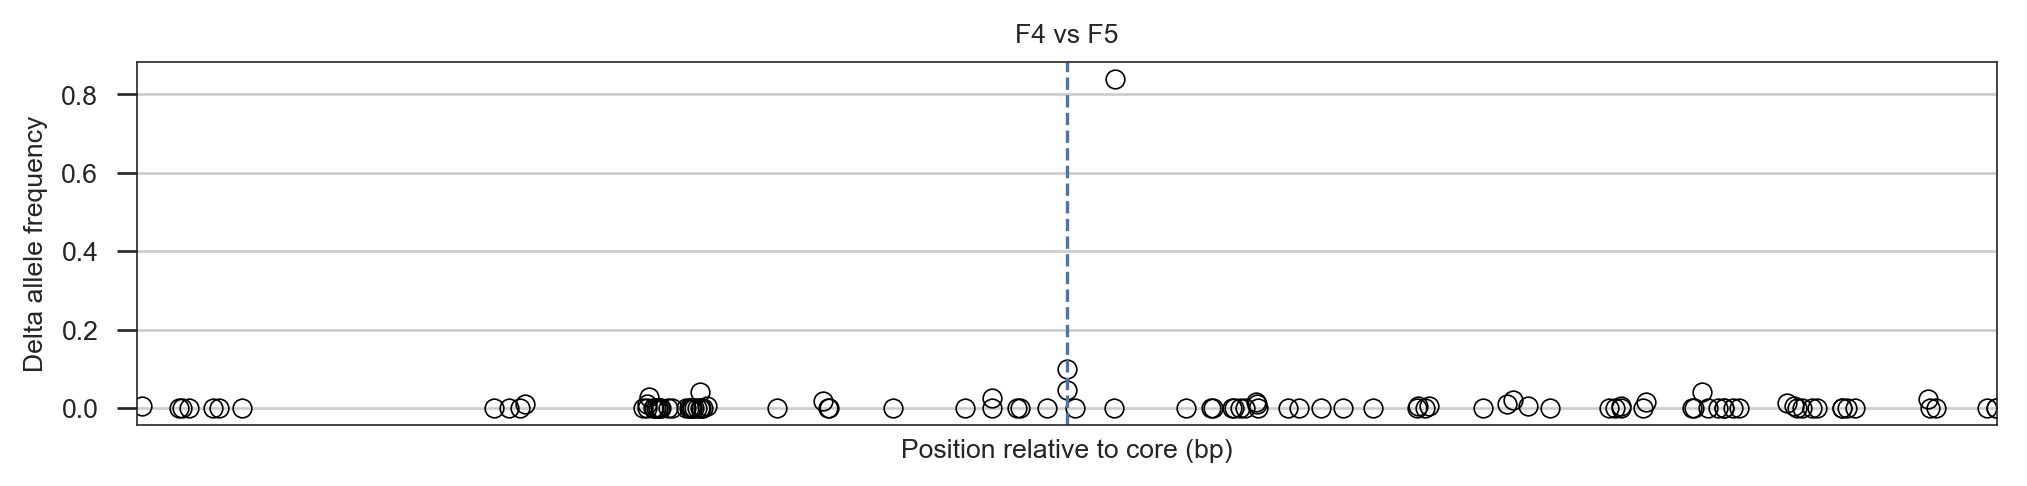

In [56]:
def analyse_995F_core_region():
    core = pos_995F
    flank = 5000
    for set1, set2 in itertools.combinations(outbreak_labels[:5], 2):
        plot_delta_af(core, flank, set1, set2)
        plt.show()
        
analyse_995F_core_region()

In [57]:
outbreak_labels[5:]

['S1', 'S2', 'S3', 'S4', 'S5']

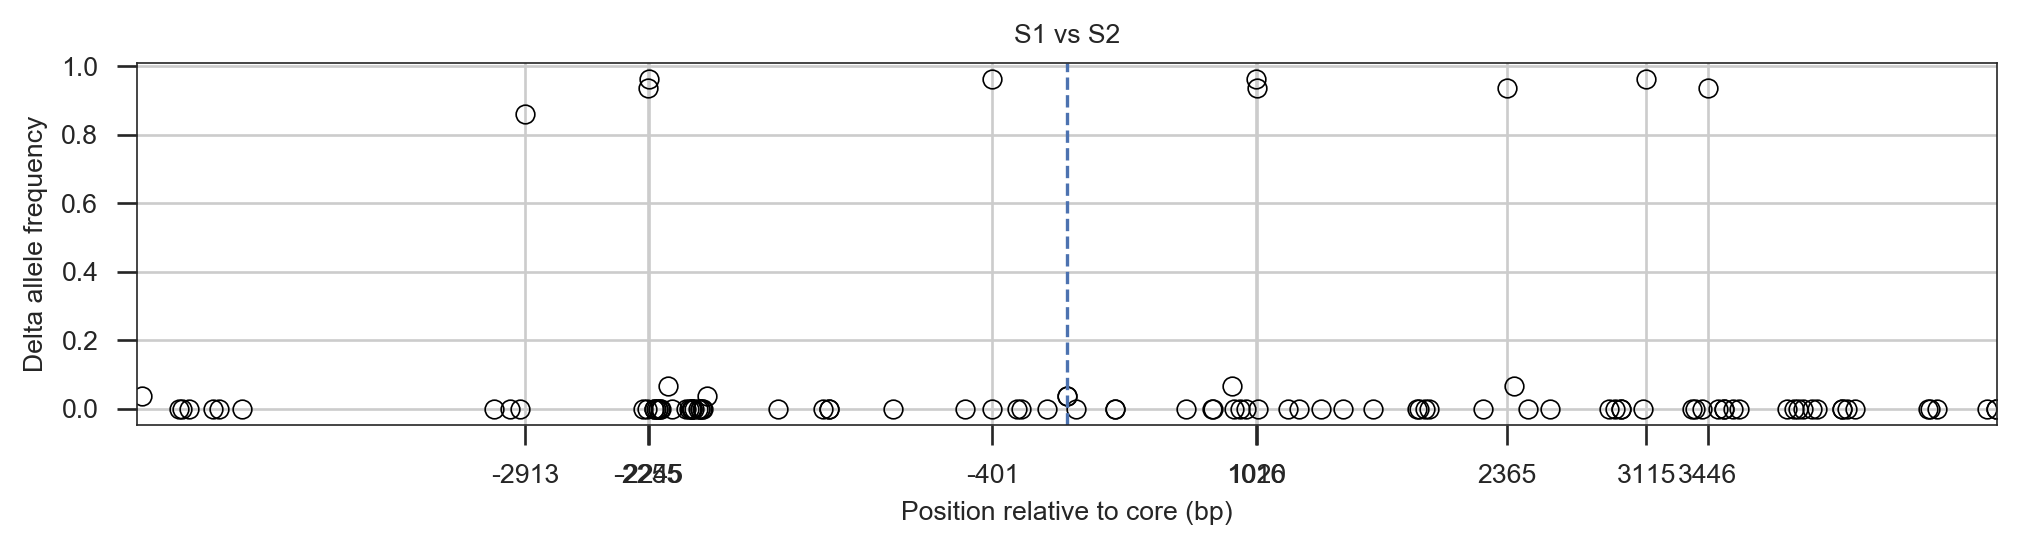

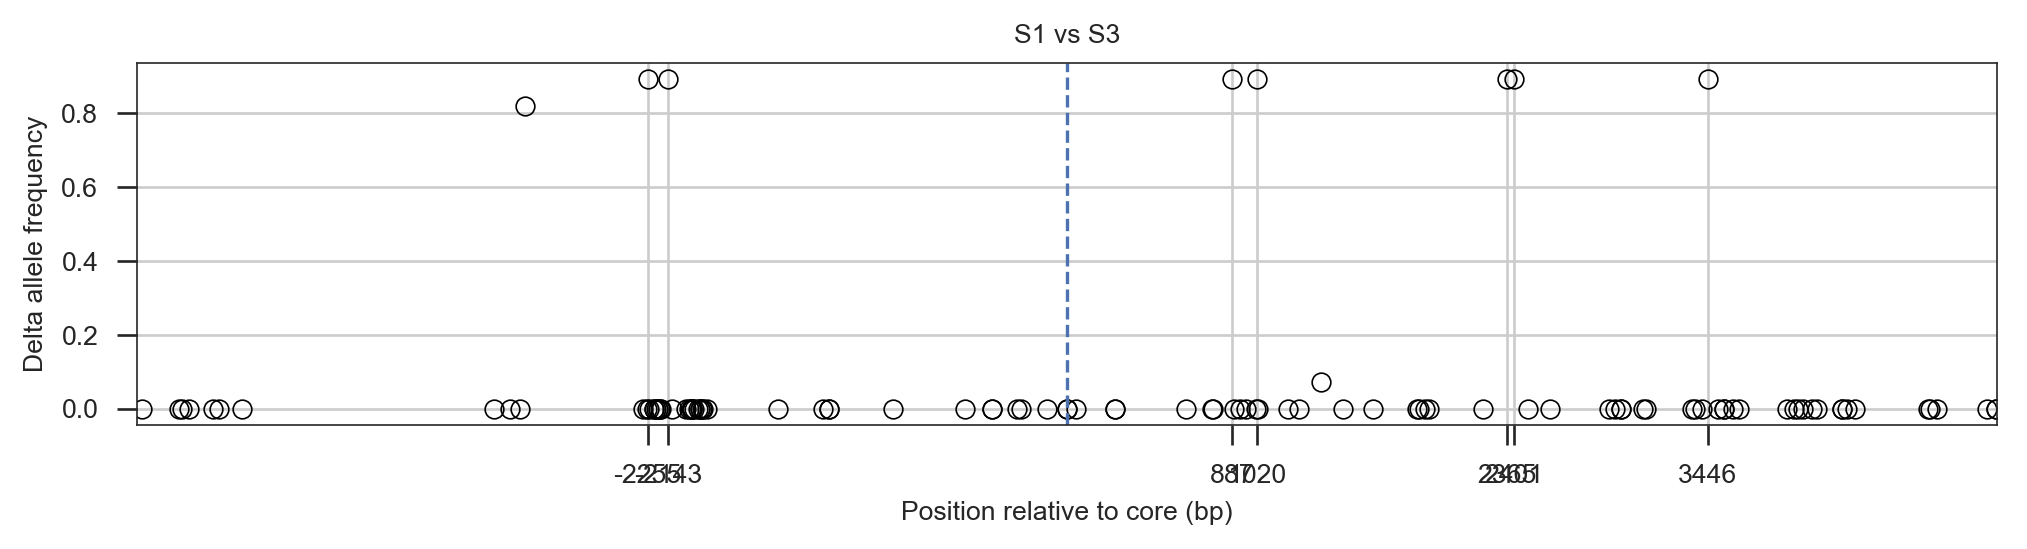

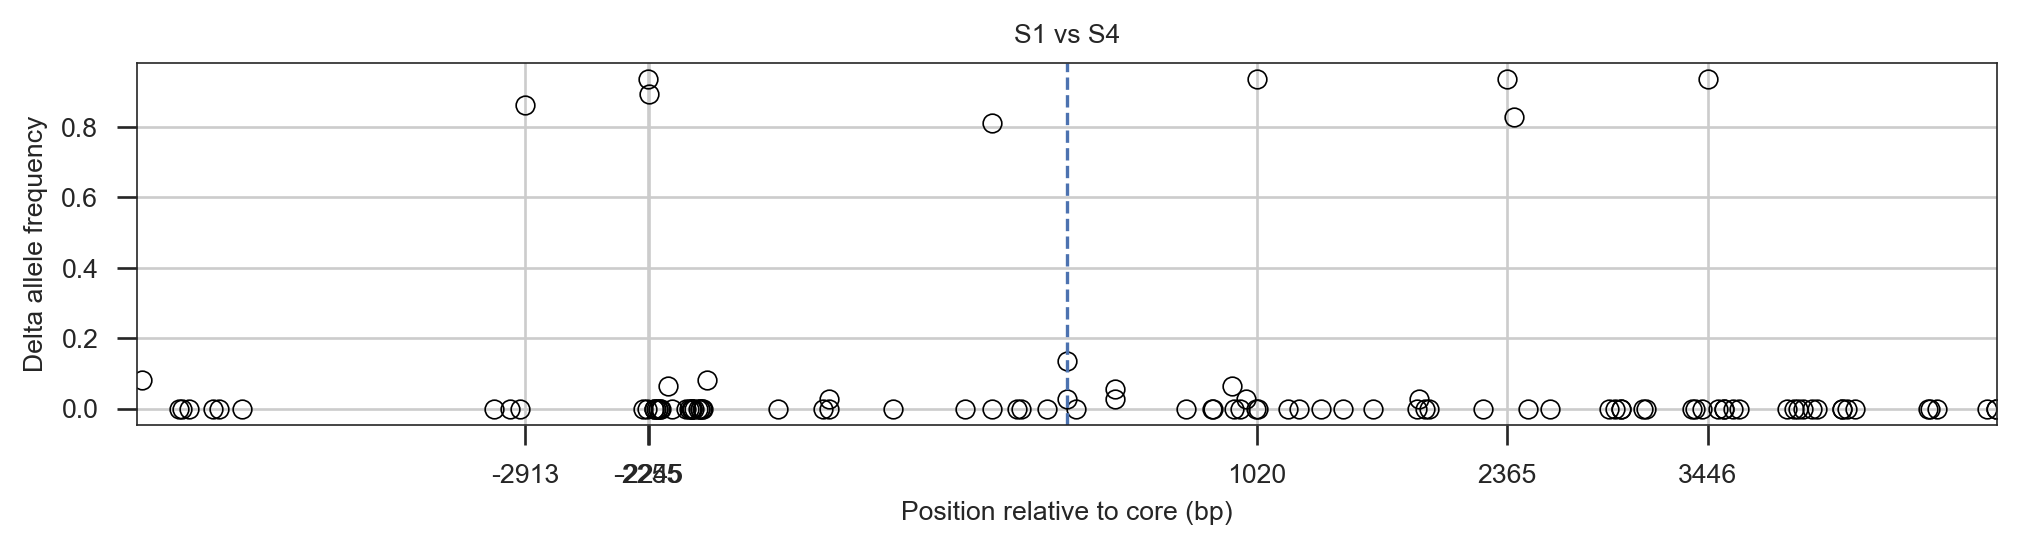

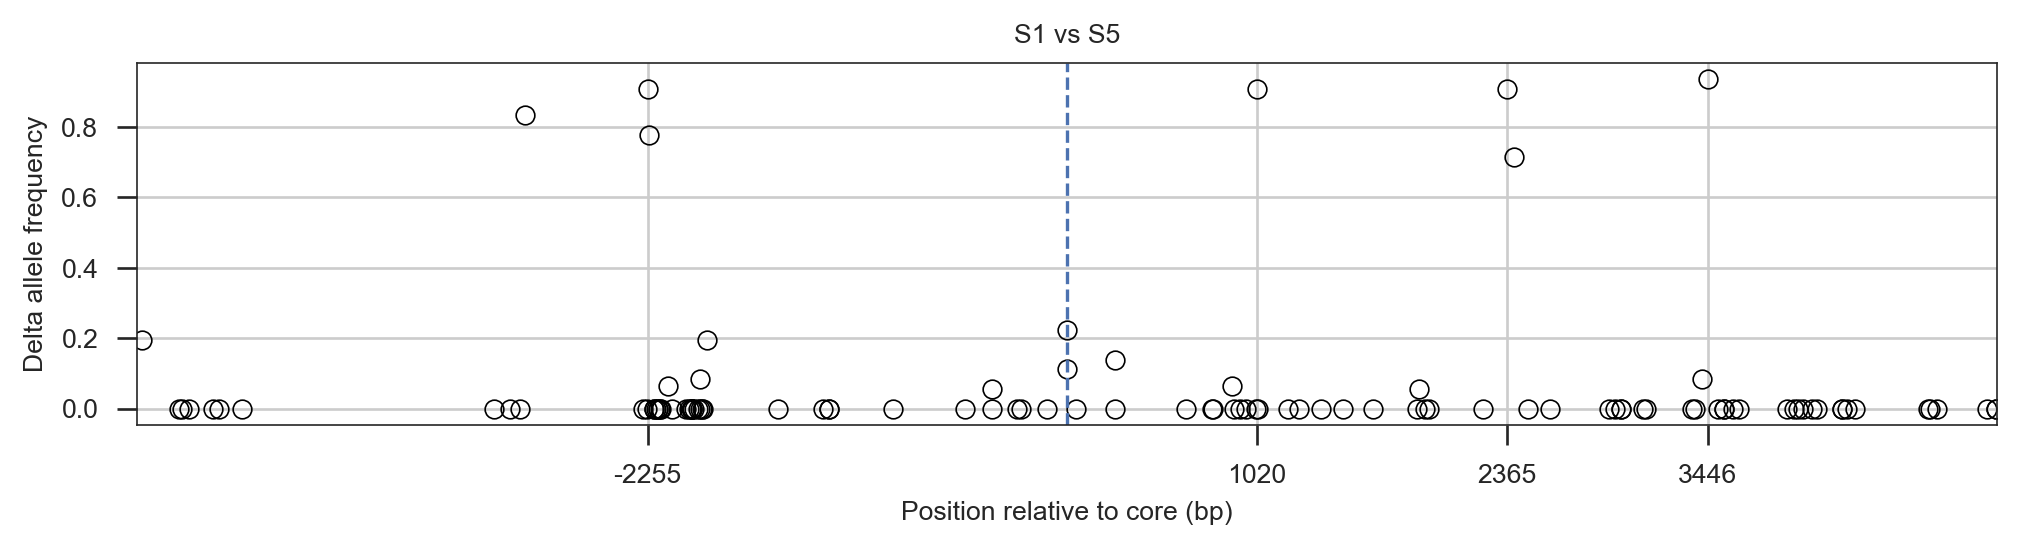

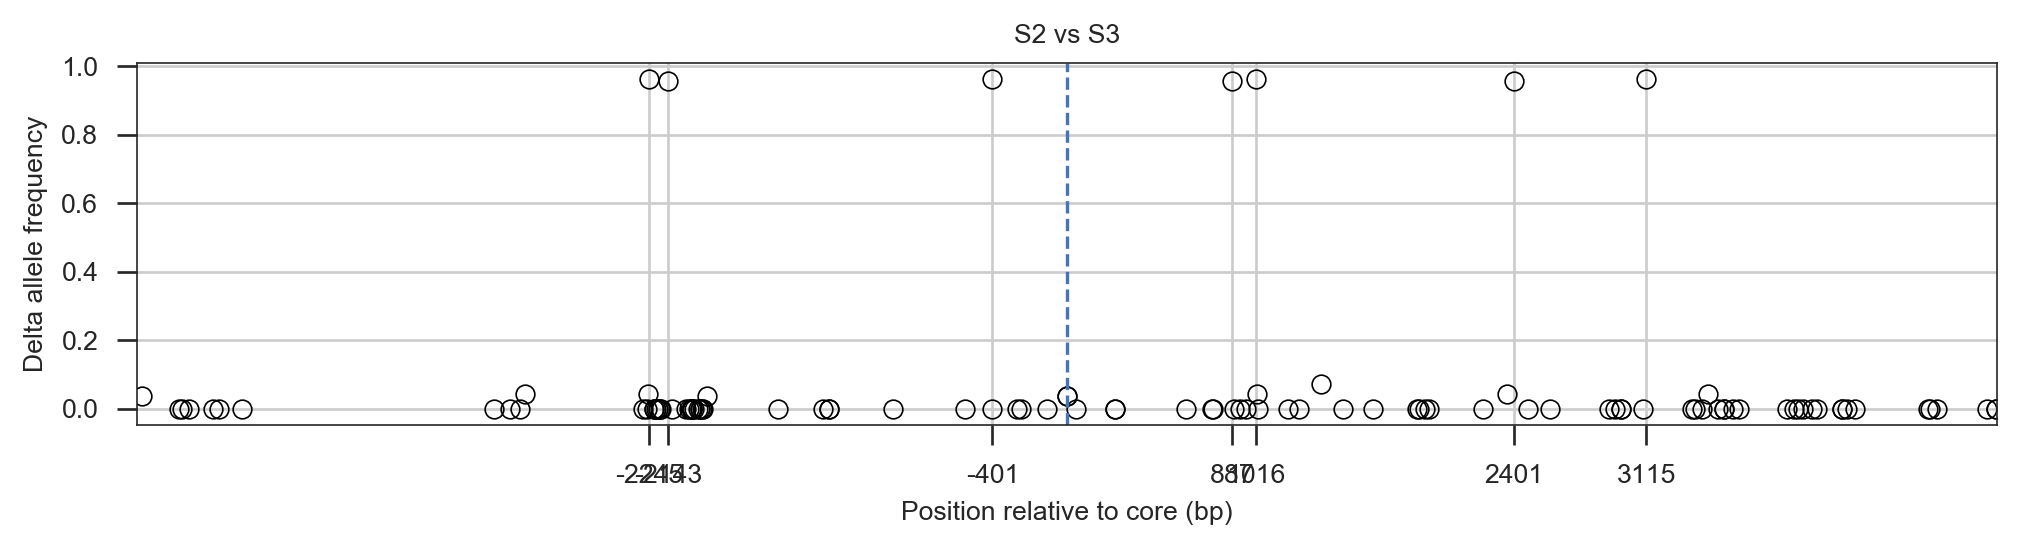

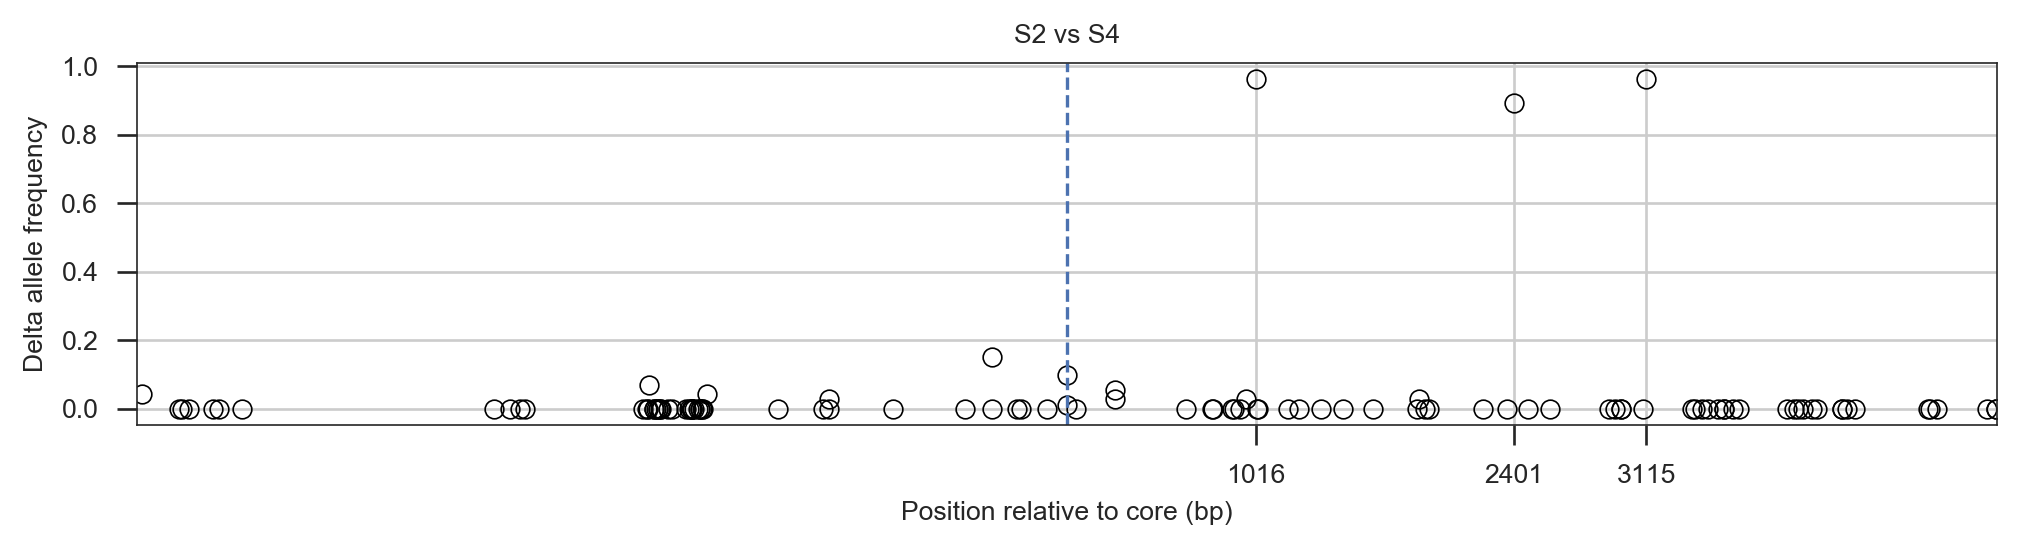

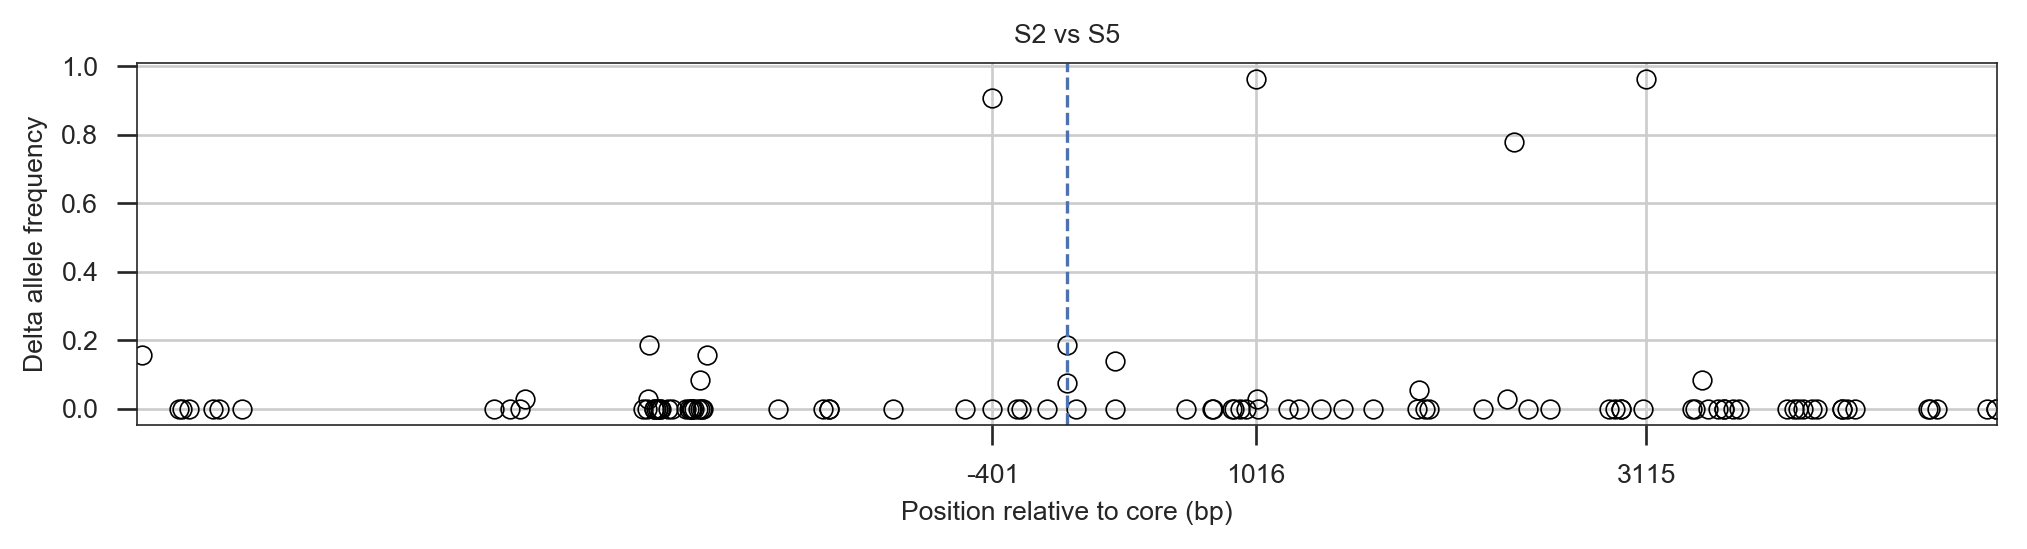

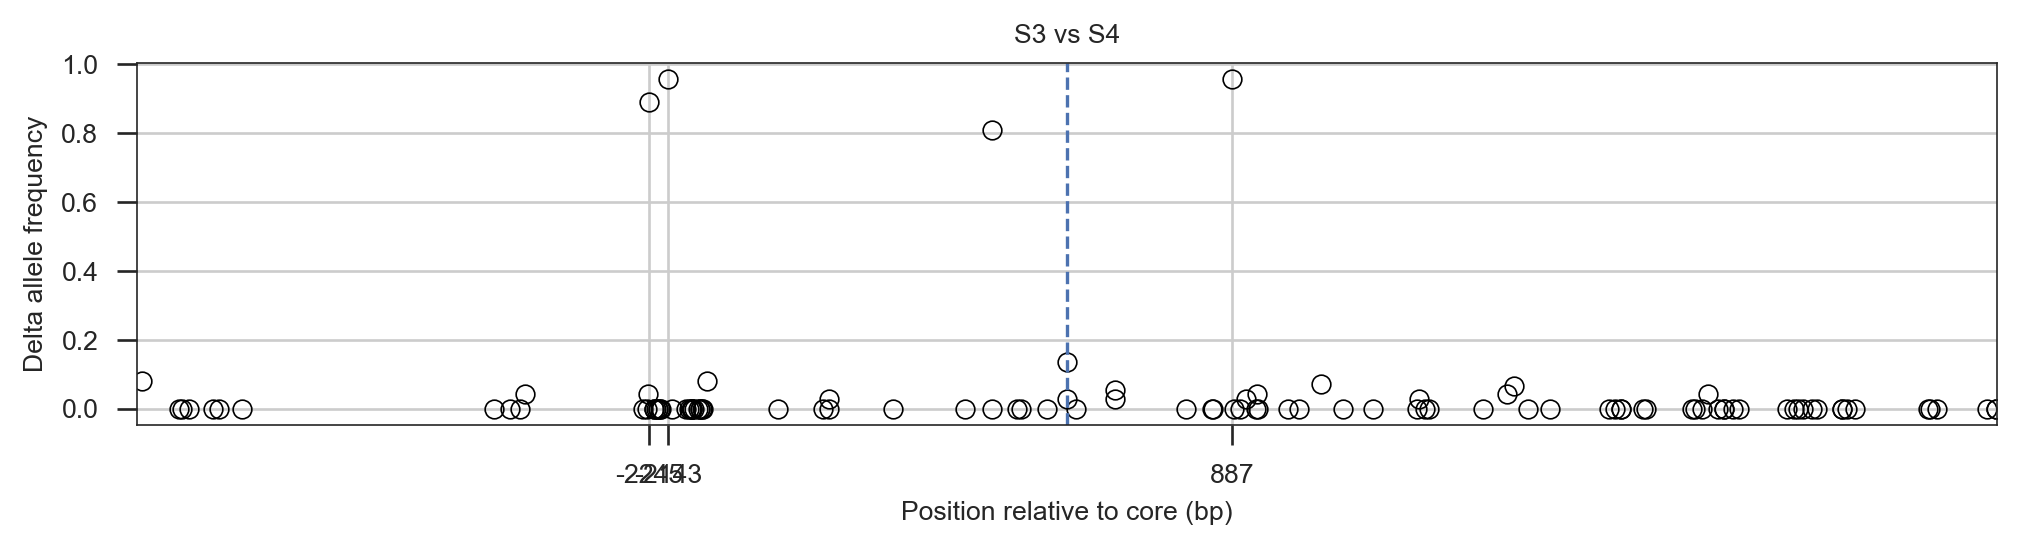

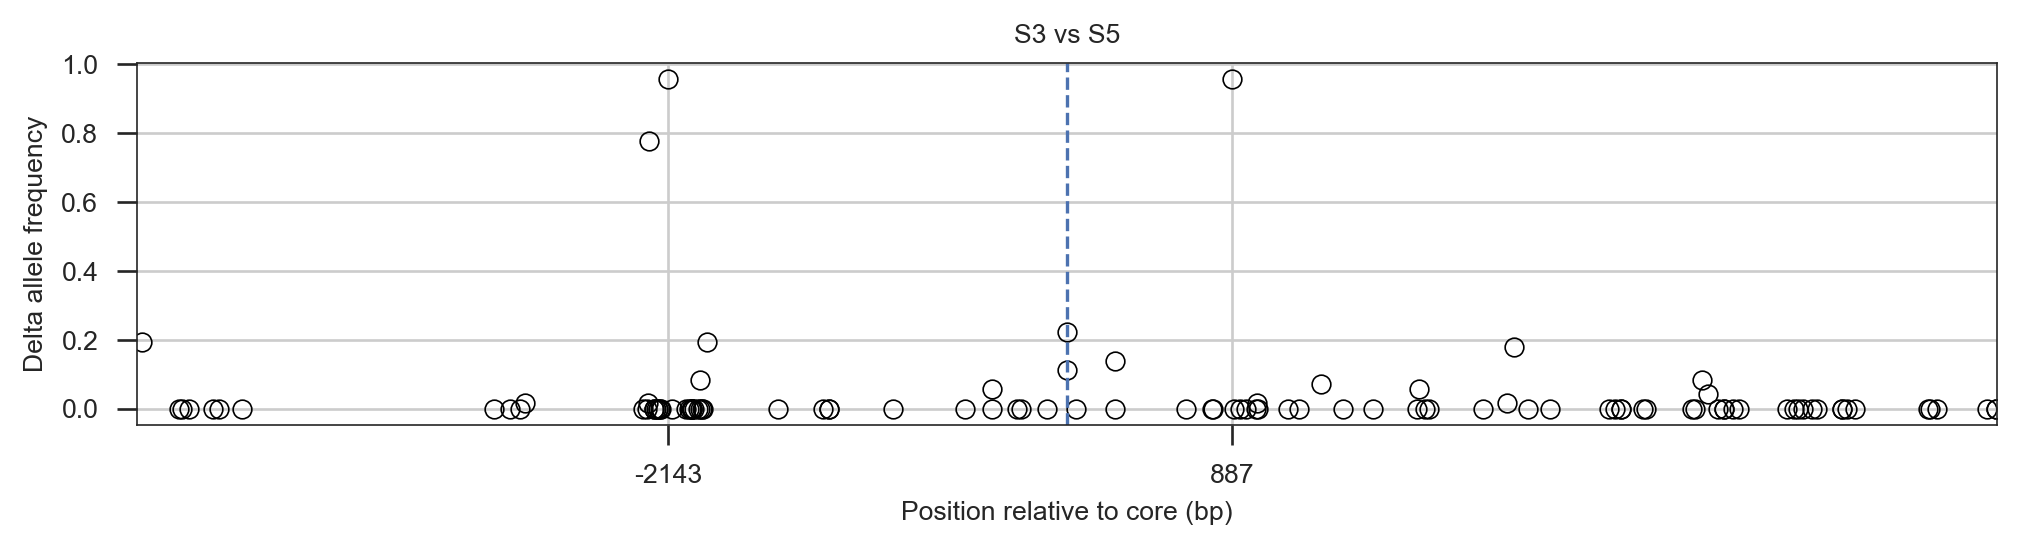

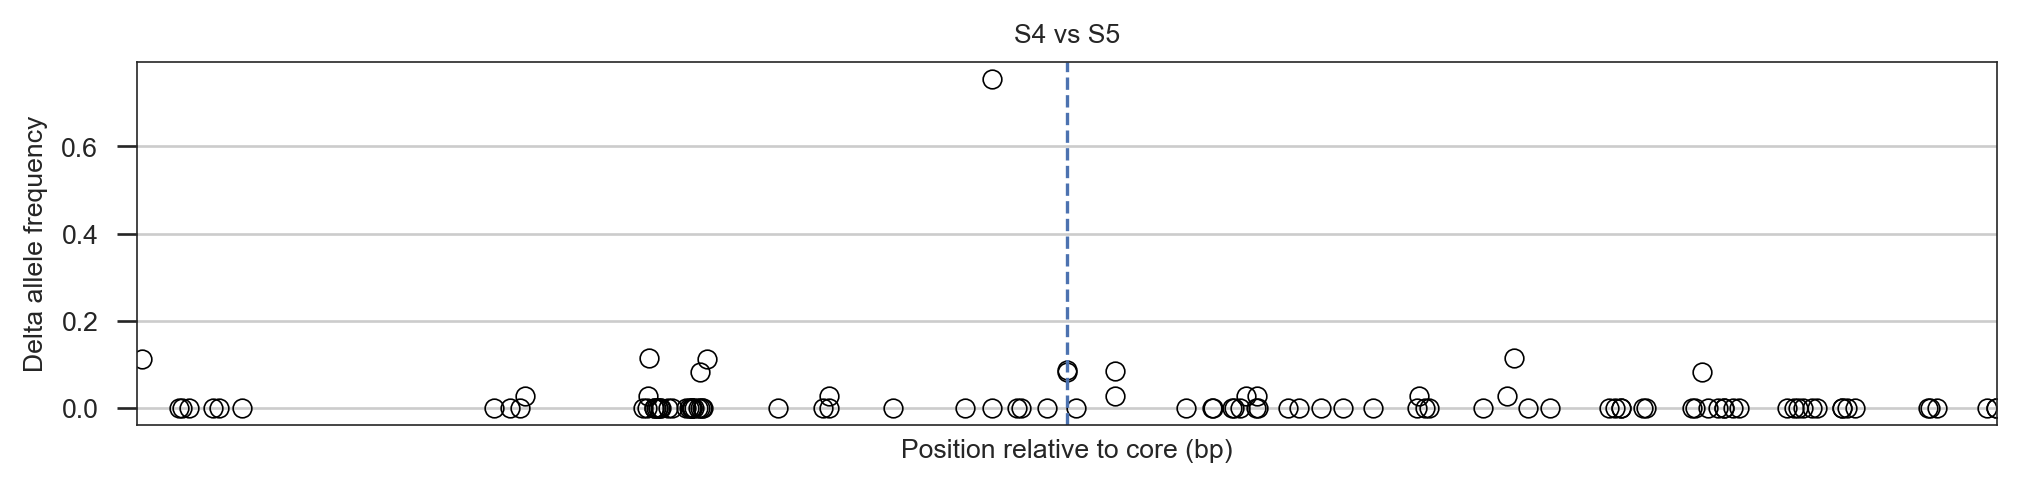

In [58]:
def analyse_995S_core_region():
    core = pos_995S
    flank = 5000
    for set1, set2 in itertools.combinations(outbreak_labels[5:], 2):
        plot_delta_af(core, flank, set1, set2)
        plt.show()
        
analyse_995S_core_region()

In [59]:
target_sets = clust_dict.copy()
wt = set(range(haps_ehh.shape[1]))
for s in clust_dict.values():
    wt = wt - s
target_sets['wt'] = wt
target_labels = sorted(target_sets)
target_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5', 'wt']

In [60]:
def extract_core_haplotypes(start, stop, min_count=14):

    loc_region = pos_ehh.locate_range(start, stop)
    haps_region = haps_ehh[loc_region]
    ret = []

    distinct_sets = haps_region.distinct()
    for s in distinct_sets:
        isecs = [len(s.intersection(target_sets[l])) for l in target_labels]
        label = target_labels[np.argmax(isecs)]
        if len(s) >= min_count:
            ret.append((label, s))
            print(label, len(s), *['%s:%s/%s (%.1f%%)' % (l, len(s.intersection(o)), len(o), len(s.intersection(o)) * 100 / len(o)) 
                                   for l, o in sorted(target_sets.items())
                                   if s.intersection(o)])
            
    return ret

In [61]:
start = pos_995S
stop = pos_995S + 3870
kdr_core_haps = extract_core_haplotypes(start, stop)

F1 468 F1:447/465 (96.1%) F4:2/42 (4.8%) F5:1/194 (0.5%) S5:2/36 (5.6%) wt:16/337 (4.7%)
F5 188 F3:2/53 (3.8%) F4:2/42 (4.8%) F5:167/194 (86.1%) S2:3/79 (3.8%) S4:1/37 (2.7%) S5:2/36 (5.6%) wt:11/337 (3.3%)
S3 153 S1:7/108 (6.5%) S3:146/165 (88.5%)
S1 108 S1:101/108 (93.5%) S3:7/165 (4.2%)
S2 79 F5:3/194 (1.5%) S2:76/79 (96.2%)
S4 73 F1:3/465 (0.6%) F5:3/194 (1.5%) S4:32/37 (86.5%) S5:28/36 (77.8%) wt:7/337 (2.1%)
wt 51 F1:1/465 (0.2%) F3:2/53 (3.8%) F4:2/42 (4.8%) F5:2/194 (1.0%) wt:44/337 (13.1%)
F3 51 F3:45/53 (84.9%) F4:1/42 (2.4%) F5:2/194 (1.0%) wt:3/337 (0.9%)
wt 38 F1:1/465 (0.2%) F3:1/53 (1.9%) F5:2/194 (1.0%) S5:1/36 (2.8%) wt:33/337 (9.8%)
wt 37 wt:37/337 (11.0%)
F4 37 F1:2/465 (0.4%) F3:1/53 (1.9%) F4:28/42 (66.7%) F5:2/194 (1.0%) wt:4/337 (1.2%)
wt 23 S4:1/37 (2.7%) S5:2/36 (5.6%) wt:20/337 (5.9%)
wt 21 wt:21/337 (6.2%)
wt 20 F4:6/42 (14.3%) F5:2/194 (1.0%) S4:1/37 (2.7%) wt:11/337 (3.3%)
wt 20 F1:1/465 (0.2%) F4:1/42 (2.4%) F5:5/194 (2.6%) wt:13/337 (3.9%)
wt 20 F1:7/465 

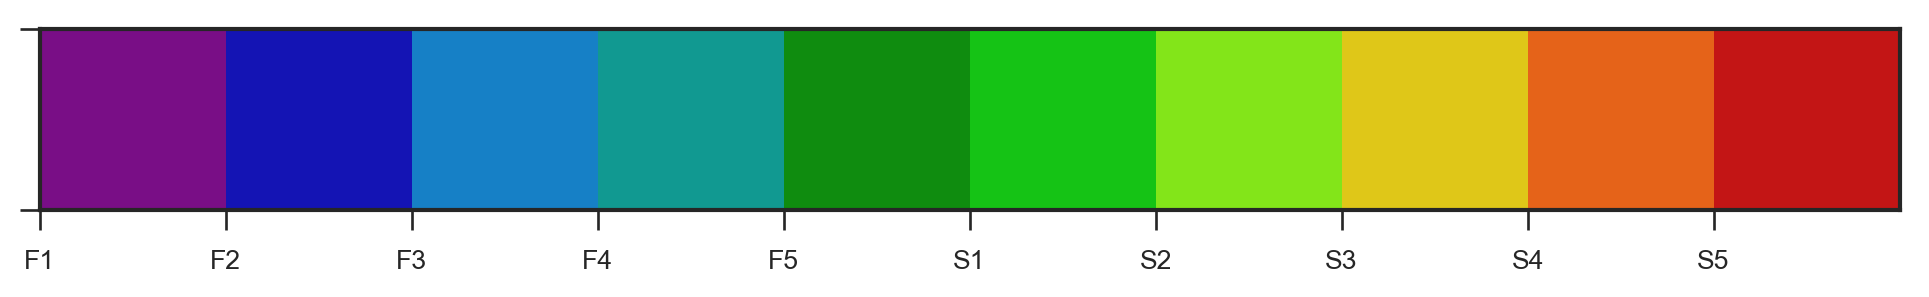

In [65]:
outbreak_palette = sns.color_palette('spectral', n_colors=len(outbreak_labels), desat=0.8)
sns.palplot(outbreak_palette)
plt.gca().set_xticklabels(outbreak_labels)
outbreak_colors = dict(zip(outbreak_labels, outbreak_palette))

In [62]:
sns.set_style('white')
sns.set_style('ticks')

In [63]:
def plot_ehh_decay(core, core_haps, flank=1000000, ax=None):
    
    loc_right = pos_ehh.locate_range(core, core + flank)
    haps_right = haps_ehh[loc_right]
    pos_right = pos_ehh[loc_right]

    loc_left = pos_ehh.locate_range(core - flank, core)
    haps_left = haps_ehh[loc_left]
    pos_left = pos_ehh[loc_left]
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2.4))
        sns.despine(ax=ax, offset=5)

    labels = set()
    for l, s in core_haps:
        labels.add(l)
        
        if l in outbreak_colors:
            color = outbreak_colors[l]
            lw = 2
        else:
            # TODO
            color = 'k'
            lw = .5
        haps_right_core = haps_right.take(sorted(s), axis=1)
        haps_left_core = haps_left.take(sorted(s), axis=1)
        ehh_decay_right = allel.ehh_decay(haps_right_core)
        ehh_decay_left = allel.ehh_decay(haps_left_core[::-1])

        ax.plot(pos_right, ehh_decay_right, color=color, lw=lw)
        ax.plot(pos_left, ehh_decay_left[::-1], color=color, lw=lw)
        
    ax.set_xlim(core - flank, core + flank)
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_xticklabels(['%.1f' % (t/1e6) for t in ax.get_xticks()])
    ax.set_ylim(0, 1.02)
    ax.set_ylabel('EHH')
    ax.grid(axis='y')
    
    handles = []
    for l in sorted(labels):
        if l in outbreak_colors:
            color = outbreak_colors[l]
            lw = 2
        else:
            # TODO
            color = 'k'
            lw = .5
        handles.append(plt.Line2D([0, 0], [0, 0], color=color, lw=lw, label=l))
    legend = ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper right', labelspacing=.3,
                       frameon=True, framealpha=1, title='Core haplotype')
    plt.setp(legend.get_title(), fontsize=base_font_size)

    if fig:
        fig.tight_layout()


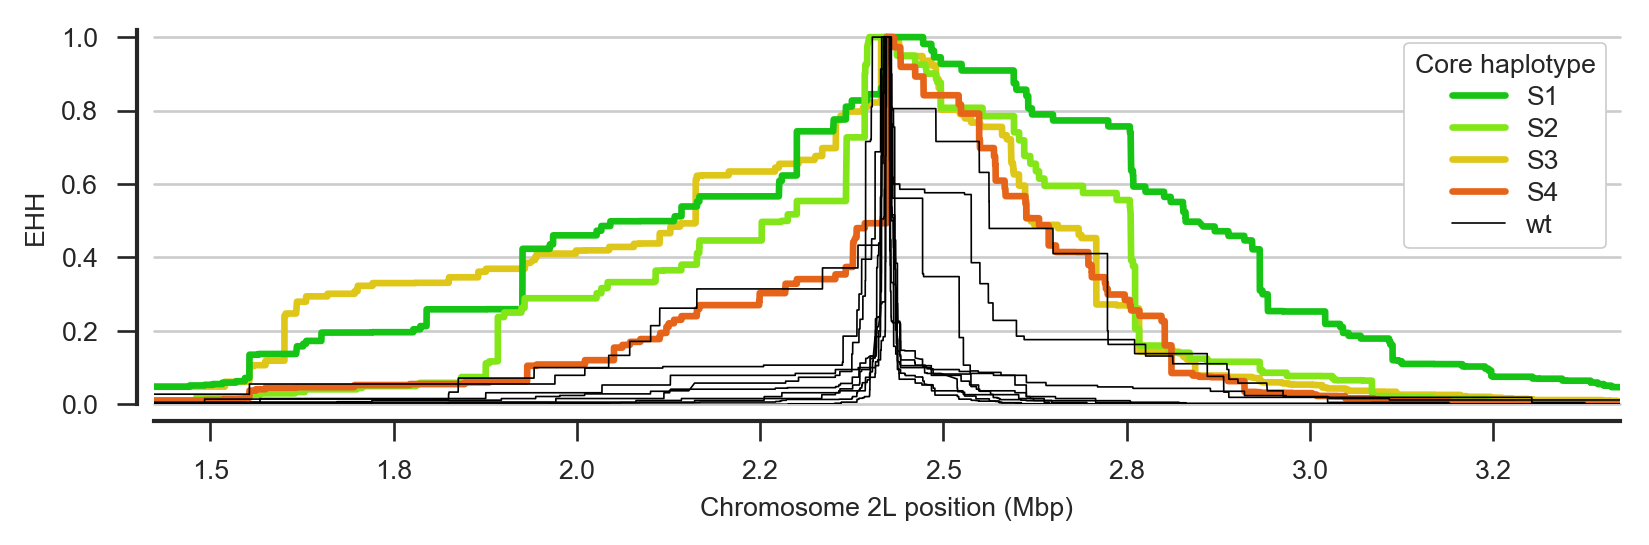

In [70]:
plot_ehh_decay(pos_995S, [(l, s) for l, s in kdr_core_haps if l.startswith('S') or l == 'wt'])


AttributeError: module 'ag1k.phase1_ar3' has no attribute 'genome'

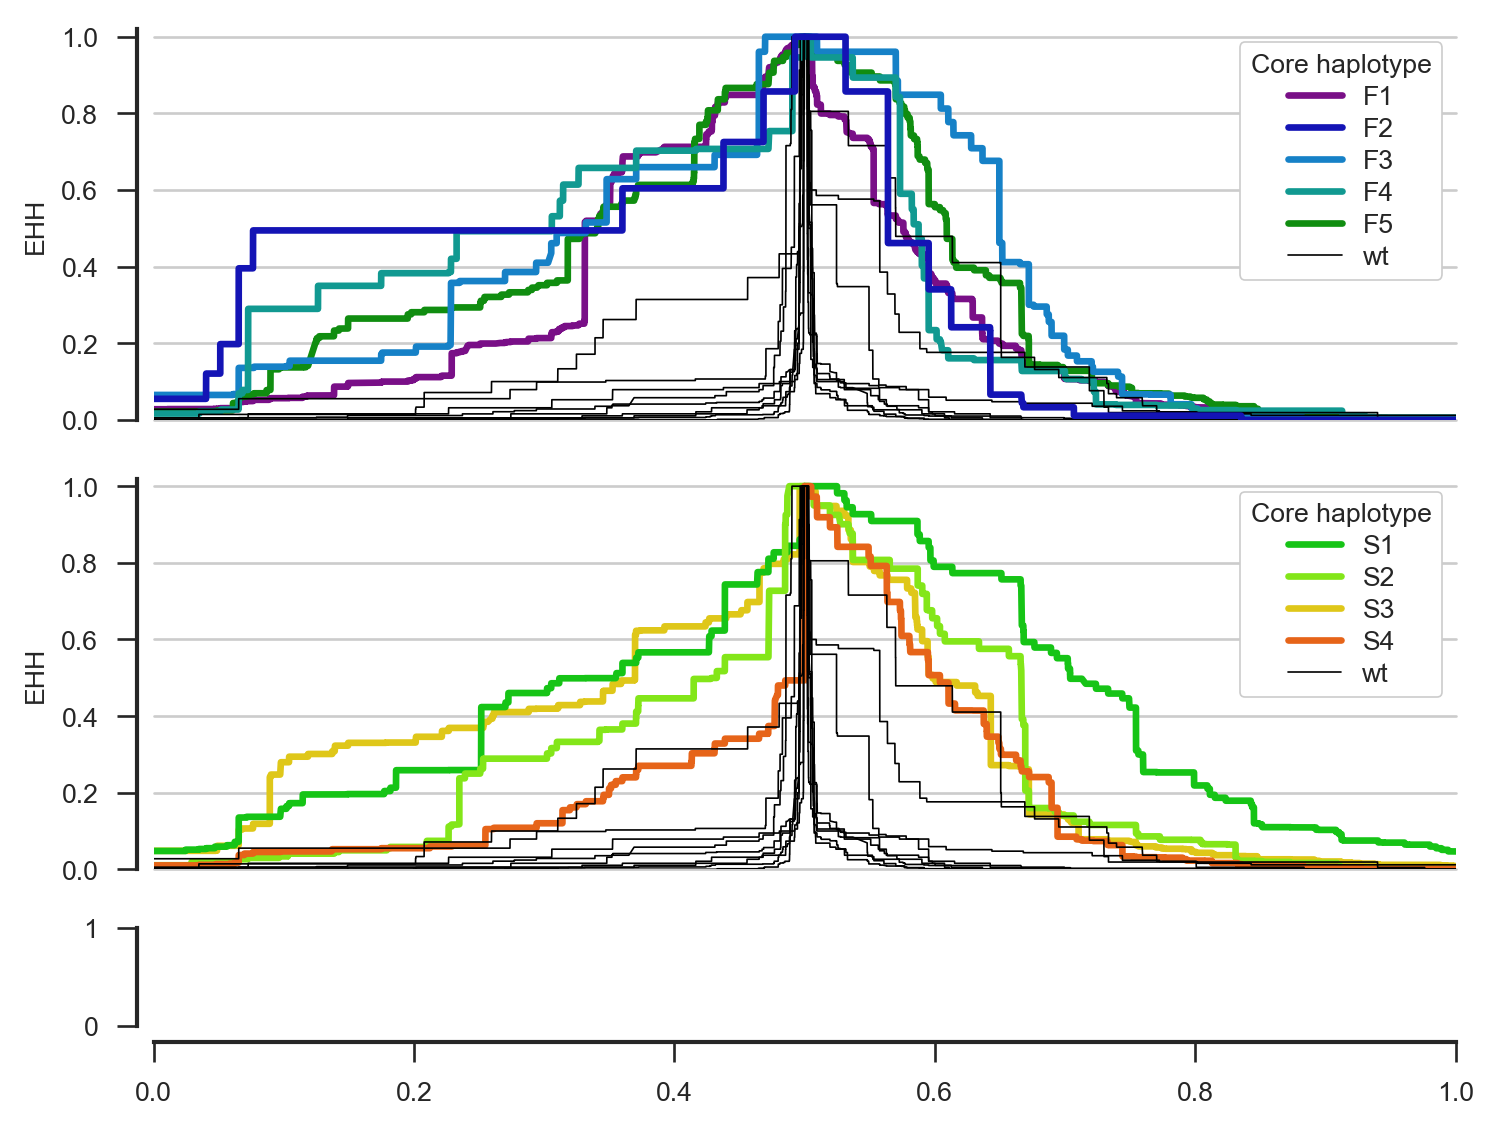

In [69]:
def fig_kdr_ehh_decay(figsize=(7, 5.5), fn=None, save_dpi=150):
    core = pos_995S
    flank = 1000000

    fig = plt.figure(figsize=figsize)
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[4, 4, 1])

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, [(l, s) for l, s in kdr_core_haps if l.startswith('F') or l == 'wt'], ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')

    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, [(l, s) for l, s in kdr_core_haps if l.startswith('S') or l == 'wt'], ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')


    ax = fig.add_subplot(gs[2])
    sns.despine(ax=ax, offset=5)
    plot_genes(phase1_ar3.genome, phase1_ar3.geneset_agamp42_fn, ax=ax,
               chrom='2L', start=core-flank, stop=core+flank, labels=gene_labels, label=True, label_unnamed=False)    
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_xticklabels(['%.1f' % (t/1e6) for t in ax.get_xticks()])
    
    fig.tight_layout()
    if fn:
        fig.savefig(fn, bbox_inches='tight', dpi=save_dpi, jpeg_quality=100)
    
fig_kdr_ehh_decay(fn='../artwork/ehh_decay_old_clusters.pdf')